In [1]:
!tree experiment_results/

experiment_results/
└── 2k
    └── medium
        ├── split_0.5
        │   ├── targetKhz:_0.5__obskHz:_0.25.txt
        │   ├── targetKhz:_0.5__obskHz:_0.5.txt
        │   ├── targetKhz:_0.5__obskHz:_0.75.txt
        │   ├── targetKhz:_0.75__obskHz:_0.25.txt
        │   ├── targetKhz:_0.75__obskHz:_0.5.txt
        │   ├── targetKhz:_0.75__obskHz:_0.75.txt
        │   ├── targetKhz:_1.0__obskHz:_0.25.txt
        │   ├── targetKhz:_1.0__obskHz:_0.5.txt
        │   └── targetKhz:_1.0__obskHz:_0.75.txt
        └── split_0.9
            ├── targetKhz:_0.5__obskHz:_0.25.txt
            ├── targetKhz:_0.5__obskHz:_0.5.txt
            ├── targetKhz:_0.5__obskHz:_0.75.txt
            ├── targetKhz:_0.75__obskHz:_0.25.txt
            ├── targetKhz:_0.75__obskHz:_0.5.txt
            ├── targetKhz:_0.75__obskHz:_0.75.txt
            ├── targetKhz:_1.0__obskHz:_0.25.txt
            └── targetKhz:_1.0__obskHz:_0.5.txt

4 directories, 17 files


In [2]:
%run -i '../MARIOS/PyFiles/imports.py'
%run -i '../MARIOS/PyFiles/helpers.py'
%run -i "../MARIOS/PyFiles/experiment.py"
from tqdm.notebook import trange, tqdm
def compare(truth, 
            unif_w_pred = None, 
            exp_w_pred = None, 
            ip_pred = None,
            columnwise = False,
            verbose = False):
    """
    This function provides two things, conditional on the columnwise variable.
    columnwise = False: cross-model comparison of nrmse
    
    columnwise = True: model nrmse correlary for each point.
    """
    nrmse_inputs = {"truth" : truth, "columnwise" : columnwise}
    pred_list = [unif_w_pred, exp_w_pred, ip_pred]
    pred_dicts = [{"pred_": prediction, **nrmse_inputs} for prediction in pred_list]
    
    def conditional_nrmse(inputs):
        return None if not inputs["pred_"] else nrmse(**inputs) # check if prediction is empty
        #if _nrmse:
        #    return _nrmse
    
    
    unif_nrmse, exp_nrmse, ip_nrmse = [nrmse(**i) for i in pred_dicts]
    
    
    hi = """
    if type(unif_w_pred) != type(None):
        unif_nrmse = nrmse(pred_ = unif_w_pred, **nrmse_inputs)
        
    if type(exp_w_pred) != type(None):
        exp_nrmse  = nrmse(pred_  = exp_w_pred , **nrmse_inputs)
    
    if type(ip_pred) != type(None):
        ip_nrmse   = nrmse(pred_  = ip_pred , **nrmse_inputs)
    """
    ip_res = {"nrmse" : ip_nrmse, "pred" : ip_pred}
        
    
    assert type(columnwise) == bool, "columnwise must be a boolean"
    
    if not columnwise:
        if verbose:
            print("cubic spline interpolation nrmse: " + str(ip_res["nrmse"]))
            print("uniform weights rc nrmse: " + str(unif_nrmse))
            print("exponential weights rc nrmse: " + str(exp_nrmse))
            print("creating barplot")
        
        unif_and_ip_dict = {"interpolation" : ip_res["nrmse"], "uniform rc" : unif_nrmse}
        exp_dict = {"exponential rc" : exp_nrmse}
        
        if type(exp_w_pred) != type(None):
            df = pd.DataFrame({"interpolation" : ip_res["nrmse"], 
                               "uniform rc" : unif_nrmse, 
                               "exponential rc" : exp_nrmse}, index = [0])
        else:
            df = pd.DataFrame({"interpolation" : ip_res["nrmse"], 
                               "uniform rc" : unif_nrmse}, index = [0])
        display(df)

        plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
        sns.catplot(data = df, kind = "bar")
        plt.title("model vs nrmse")
        plt.ylabel("nrmse")
        improvement = []
        for rc_nrmse in[unif_nrmse, exp_nrmse]:
            impr_spec = ((ip_res["nrmse"] - rc_nrmse)/ip_res["nrmse"]) * 100
            impr_spec = [round(impr_spec,1)]
            improvement += impr_spec

        pct_improve_unif, pct_improve_exp = improvement
        if pct_improve_unif > 0:
            print("unif improvement vs interpolation: nrmse " + str(-pct_improve_unif) + "%")
        else:
            print("rc didn't beat interpolation: nrmse +" + str(-pct_improve_unif) + "%")
        
        if pct_improve_exp > 0:
            print("exp improvement vs interpolation: nrmse " + str(-pct_improve_exp) + "%")
        else:
            print("rc didn't beat interpolation: nrmse +" + str(-pct_improve_exp) + "%")

        impr_rc_compare = round(((unif_nrmse - exp_nrmse)/unif_nrmse) * 100,1)

        if impr_rc_compare > 0:
            print("exp rc improvement vs unif rc: nrmse " + str(-impr_rc_compare) + "%")
        else:
            print("exp weights didn't improve rc: nrmse +" + str(-impr_rc_compare) + "%")
    else:
        print("creating first figure")
        model_names = ["interpolation", "uniform rc", "exponential rc"]
        for i, model_rmse_np in enumerate([ip_res["nrmse"], unif_nrmse, exp_nrmse]):
            model_rmse_pd = pd.melt(pd.DataFrame(model_rmse_np.T))
            model_rmse_pd.columns = ["t","y"]
            model_rmse_pd["model"] = model_names[i]
            if not i: # check if i == 0
                models_pd = model_rmse_pd
            else:
                models_pd = pd.concat([models_pd, model_rmse_pd ], axis = 0)
        fig, ax = plt.subplots(1,1, figsize = (11, 6))
        sns.lineplot(x = "t", y = "y", hue = "model", data = models_pd, ax = ax)
        ax.set_title("model vs rmse")
        ax.set_ylabel("nrmse")
        ax.set_xlabel("Test idx")
        
def get_experiment(json_obj, verbose = False, compare_ = True, plot_split = True):
    
    experiment_ = EchoStateExperiment(**json_obj["experiment_inputs"])
    
    obs_inputs = json_obj["get_observer_inputs"]
    obs_inputs["method"] = "exact"
    
    experiment_.obs_idx, experiment_.resp_idx  = json_obj["obs_idx"], json_obj["resp_idx"]
    
    experiment_.get_observers(**obs_inputs, 
                              plot_split = plot_split)
    if verbose == True:
        print("experiment inputs: " + str(json_obj["experiment_inputs"]))
        print("get_obs_inputs: " + str(obs_inputs))
        print("Train.shape: " + str(experiment_.Train.shape))
        print("Saved_prediction.shape: " + str(np.array(json_obj["prediction"]["uniform"]).shape))
        
        
    
        
    experiment_.already_trained(json_obj["best arguments"]["uniform"], exponential = False)
    
    
    
    #print(experiment_.prediction.shape)
    #print(experiment_.Test.shape)
    
    experiment_.Train, experiment_.Test = recover_test_set(json_obj)
    
    ### which line is missing?
    xx = range(experiment_.prediction.shape[0])
    
    
    #plt.imshow( experiment_.prediction)
    #plt.show()
    """
    #plt.imshow( experiment_.Test)
    #plt.show()
    
    sns.lineplot( x = xx, y = experiment_.prediction[ : , 0 ], label = "prediction from cluster 0 ")
    sns.lineplot( x = xx, y = experiment_.prediction[ : , 0 ], label = "prediction from cluster 1 ")
    sns.lineplot( x = xx, y = experiment_.Test[ : , 0 ], label = "actual data 0")
    sns.lineplot( x = xx, y = experiment_.Test[ : , -1 ], label = "actual data 1")
    #plt.plot(experiment_.Test[ : , 1 ])
    """
    
    #experiment_.plot_timeseries(method = "avg")
    if compare_:
        n_keys = len(list(json_obj["prediction"].keys()))
        #if  n_keys == 3:
        unif_w_pred, exp_w_pred = json_obj["prediction"]["uniform"], json_obj["prediction"]["exponential"]
        ip_pred = json_obj["prediction"]["interpolation"]
        unif_w_pred, exp_w_pred, ip_pred = [np.array(i) for i in [unif_w_pred, exp_w_pred, ip_pred]]
        """
        if verbose == True:
            for i in [[unif_w_pred, "unif pred"],
                      [exp_w_pred, "exp pred"],
                      [ip_pred, "ip pred"],
                      [np.array(experiment_.Test), "Test" ]]:
                Shape(i)
        """
            
        compare(
            truth       = np.array(experiment_.Test), 
            unif_w_pred = unif_w_pred,
            ip_pred     = ip_pred,
            exp_w_pred  = exp_w_pred, 
            columnwise  = False,
            verbose = False)
        if n_keys == 2:
            compare(
                truth       = np.array(experiment_.Test), 
                unif_w_pred = np.array(json_obj["prediction"]["uniform"]),
                ip_pred = np.array(json_obj["prediction"]["interpolation"]),
                exp_w_pred  = None,#np.array(json_obj["prediction"]["exponential"]), 
                columnwise  = False,
                verbose = False)

    return(experiment_)
    
##CHECK IF INTERPOLATION IS RUNNING CORRECTLY (#NOWAY)

    
    #print(ip_)
    #exp_ = nrmse(pred_ = np.array(hi["prediction"]["exponential"]), truth = hiObj.xTe, columnwise = False)
    #diff += [ip_ - exp_]
    #print(exp_)
#sns.distplot(diff)

In [3]:
#TODO: Step 2: store hyper-parameter-results: Let's get some nice hyper-parameter plots.
#TODO: Step 1: check if observers are correct:
#TODO: fix


def check_shape_obs(file = "default"):
    if file == "default":
        nf = get_new_filename(exp = exp, current = True)
    else:
        nf = file
    with open(nf) as json_file: # 'non_exp_w.txt'
        datt = json.load(json_file)
    #datt = non_exp_best_args["dat"]
    #datt["obs_tr"], datt["obs_te"]   = np.array(datt["obs_tr"]), np.array(datt["obs_te"])
    #datt["resp_tr"], datt["resp_te"] = np.array(datt["resp_tr"]), np.array(datt["resp_te"])
    return(datt)

def load_data(file = "default", print_lst = ["nrmse"], bp = None, verbose = True, enforce_exp = False):
    if bp != None:
        file = bp + file
    if file == "default":
        nf = get_new_filename(exp = exp, current = True)
    else:
        nf = file
    with open(nf) as json_file: # 'non_exp_w.txt'
        datt = json.load(json_file)
    
    for i in print_lst:
        if verbose == True:
            if enforce_exp == True:
                assert len(list(print_lst.keys())) >= 3, "exp not found: " + file
            print(datt[i])
        
    return(datt)



#experiment.save_json(exp = False)
#fp = bp + 'targetKhz:_0.01__obskHz:_0.01.txt'
#fp = bp + 'targetKhz:_0.02__obskHz:_0.01.txt'
def topline(spec_path, 
            base_path = "/Users/hayden/Desktop/experiment_results/2k/medium/",
            #base_path = #"./experiment_results/..."
            verbose = False,
            print_filestructure = False):
    
    print(base_path)
    fp = base_path + spec_path
    """
    
    targetKhz:_0.02__obskHz:_0.01.txt
    │   │   │   ├── targetKhz:_0.5__obskHz:_0.5.txt
    │   │   │   └── targetKhz:_0.5__obskHz:_1.0.txt
    """
    hi = load_data(file = fp)
    if print_filestructure == True:
        for i in hi.keys():
            print(i + "/")

            if type(hi[i]) == dict:

                for j in hi[i].keys():
                    print("    " +j)
    if verbose == True:
        print("DATA STRUCTURE: (it's a dict)")
        print("/n inputs:")
        print(hi["experiment_inputs"])
        print(hi["get_observer_inputs"])

        print("/n key saved values:")
        print(hi["best arguments"])
        print(hi["nrmse"])
    return(hi)

def recover_test_set(json_obj):
    """
    This function exists for an annoying reason: there is a shitty bug in my code.
    A timeline is dropped and surely this is minor if we can just recover the index by exact indices.
    """
    
    experiment_ = EchoStateExperiment(**json_obj["experiment_inputs"])
    
    obs_inputs = json_obj["get_observer_inputs"]
    obs_inputs["method"] = "exact"
    

    
    obs_idx, resp_idx = json_obj["obs_idx"], json_obj["resp_idx"]
    A_subset = experiment_.A.copy()
    
    # pred shape
    pred_shape = np.array(json_obj["prediction"]["interpolation"]); pred_shape = pred_shape.shape[0]                   
    
    A = experiment_.A
    
    train_len = (A.shape[0] - pred_shape)
    Train_Tmp, Test_Tmp  = A[:train_len, resp_idx], A[train_len:, resp_idx]
    
    
    
    #print(Test_Tmp.shape)
    return(Train_Tmp, Test_Tmp)

#recover_test_set(hi)

# New experiments

In [4]:

complete_experiment_path_lst = [ 
    #targ 500  kHz COMPLETE
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt',
            #targ 1000 kHz COMPLETE
            '2k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_1.0__obskHz:_1.0.txt',
            
            #targ 500  Hz COMPLETE
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.5.txt', #no exp
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt', #no exp
            #targ 1000 Hz COMPLETE
            '2k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt',
            '2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt', #no exp
]
def check_splits(complete_experiment_path_lst_):
    for i in complete_experiment_path_lst_:
        experiment_ = load_data(i, bp = './experiment_results/', verbose = False)
        get_experiment(experiment_, compare = True)
        #experiment_8_obj = get_experiment(experiment_8)
        #get_experiment(i)#E, print_filestructure = False)
                #base_path = "./experiment_results/")

In [5]:
def check_for_duplicates(lst, UnqLst = True, verbose = True):
    lst_tmp = []
    duplicates = []
    for i in lst:
        if i in lst_tmp:
            
            duplicates += [i]
        else:
            lst_tmp += [i]
    if verbose == True:
        print(duplicates)
    if UnqLst:
        return(lst_tmp)
"""
def check_for_duplicates(lst, UnqLst = True, verbose = True):
    for i, item in enumerate(lst):
        if not i:
            unique_lst = []
            duplicates = []
        if item in unique_lst:
            duplicates.append(item) 
        else:
            unique_lst.append(item)
    if verbose:
        print(duplicates)
    if UnqLst:
        return(unique_lst) 
"""     

    
experiments1k = [
            "/1k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt",
            "/1k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt",
            "/1k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt"]

hi = """
for i in experiments1k:
    experiment_ = load_data(i,
                             bp = './experiment_results')
    hi = pd.DataFrame(experiment_['nrmse'], index = [0])
    hi = pd.melt(hi)
    hi.columns = ["model", "nrmse"]
    print(hi)
    sns.barplot(x = "model", y = "nrmse", data = hi)
    #experiment_obj = get_experiment(experiment_5)
"""

In [6]:
! tree experiment_results/



experiment_results/
└── 2k
    └── medium
        ├── split_0.5
        │   ├── targetKhz:_0.5__obskHz:_0.25.txt
        │   ├── targetKhz:_0.5__obskHz:_0.5.txt
        │   ├── targetKhz:_0.5__obskHz:_0.75.txt
        │   ├── targetKhz:_0.75__obskHz:_0.25.txt
        │   ├── targetKhz:_0.75__obskHz:_0.5.txt
        │   ├── targetKhz:_0.75__obskHz:_0.75.txt
        │   ├── targetKhz:_1.0__obskHz:_0.25.txt
        │   ├── targetKhz:_1.0__obskHz:_0.5.txt
        │   └── targetKhz:_1.0__obskHz:_0.75.txt
        └── split_0.9
            ├── targetKhz:_0.5__obskHz:_0.25.txt
            ├── targetKhz:_0.5__obskHz:_0.5.txt
            ├── targetKhz:_0.5__obskHz:_0.75.txt
            ├── targetKhz:_0.75__obskHz:_0.25.txt
            ├── targetKhz:_0.75__obskHz:_0.5.txt
            ├── targetKhz:_0.75__obskHz:_0.75.txt
            ├── targetKhz:_1.0__obskHz:_0.25.txt
            └── targetKhz:_1.0__obskHz:_0.5.txt

4 directories, 17 files


In [7]:
"""
            finished but publish size:
            '/1k/publish/split_0.5/targetKhz:_0.1__obskHz:_0.1.txt',
            "/1k/publish/split_0.5/targetKhz:_0.1__obskHz:_0.25.txt",
            
            ########################################################################### 1k
            completed 1k tests
            "/1k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt",
            "/1k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt",
            "/1k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt",
            "/1k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt",
            "/1k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt",
"""

def quick_write_path(freq, split, targHz, obsHz, size = "/medium"):
    if freq == 2000:
        freqStr = "2k"
    elif freq == 4000:
        freqStr = "4k"
    splitStr = "/split_" + str(split)
    targHz, obsHz = str(targHz/1000) , str(obsHz/1000)
    HzStr = "/targetKhz:_" + targHz + "__obskHz:_" +  obsHz 
    newPath = freqStr + size + splitStr + HzStr +".txt"
    return([newPath])

def quick_write_dict(freq, split, targHz, obsHz):
    dict_tmp = {'target_freq': freq, 'split': split, 'obs_hz': obsHz, 'target_hz': targHz}
    return([dict_tmp])


path_lst = []
dict_lst = []
for targ_freq in [2000, 4000]:
    for split in [0.5, 0.9]:
        for targ in list(range(500, 2001, 250)):
            for obs in list(range(500, 2001, 250)):
                path_lst += quick_write_path(freq = targ_freq, split = split, targHz = targ, obsHz = obs)
                dict_lst += quick_write_dict(freq = targ_freq, split = split, targHz = targ, obsHz = obs)


path_lst += [ 
            # the plan is to run all those tests which will give detail from the LHS. ie increasin
            # target Hz.
            ########################################################################### 2k
            #######################2k, 0.9 
            #targ 500  kHz COMPLETE
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.75.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.25.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.5.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.75.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_2.0.txt',
            
    
            

            #targ 750  H z
            '2k/medium/split_0.9/targetKhz:_0.75__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_0.75__obskHz:_1.0.txt',
    
            #targ 1000 kHz COMPLETE
            '2k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_1.0__obskHz:_1.0.txt',
            
            #targ 1250  Hz
            '2k/medium/split_0.9/targetKhz:_1.25__obskHz:_0.5.txt', 
            '2k/medium/split_0.9/targetKhz:_1.25__obskHz:_1.0.txt', 
    
            #targ 1500  Hz
            '2k/medium/split_0.9/targetKhz:_1.5__obskHz:_0.5.txt', 
            '2k/medium/split_0.9/targetKhz:_1.5__obskHz:_1.0.txt', 
    
            #targ 1750  Hz
            '2k/medium/split_0.9/targetKhz:_1.75__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_1.75__obskHz:_1.0.txt',
    
            #targ 2000  Hz
            '2k/medium/split_0.9/targetKhz:_2.0__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_2.0__obskHz:_1.0.txt',
    
            #######################2k, 0.5
            #targ 500  Hz COMPLETE
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.5.txt',
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.75.txt',
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt',
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.25.txt',
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.5.txt',
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.75.txt',
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_2.0.txt',
    
             #targ 750 Hz
             "2k/medium/split_0.5/targetKhz:_0.75__obskHz:_1.0.txt",
             "2k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.5.txt", #CHECK LATER
    
            #targ 1000 Hz
             "2k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt", #
             "2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt", #
    
            #targ 1250 Hz
             "2k/medium/split_0.5/targetKhz:_1.25__obskHz:_1.0.txt", # ABOUT TO RUN 600
             "2k/medium/split_0.5/targetKhz:_1.25__obskHz:_0.5.txt", # ABOUT TO RUN 600
    
            #targ 1500 Hz
             "2k/medium/split_0.5/targetKhz:_1.5__obskHz:_1.0.txt", # ABOUT TO RUN 1000
             "2k/medium/split_0.5/targetKhz:_1.5__obskHz:_0.5.txt", # ABOUT TO RUN 1000
    
     
             #targ 2000 Hz
             '2k/medium/split_0.5/targetKhz:_2.0__obskHz:_1.0.txt', #no exp
             
    
           ########################################################################### 4k
           #######################4k, 0.9 
           #4k, 0.9 500 target Hz COMPLETE
           "4k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt",
           "4k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt",
            
           #4k, 0.9 1000 target Hz RUNNING
           '4k/medium/split_0.9/targetKhz:_0.75__obskHz:_0.5.txt', #RUNNING 200
           '4k/medium/split_0.9/targetKhz:_0.75__obskHz:_1.0.txt', #RUNNING 200
    
           
           #4k, 0.9 1000 target Hz COMPLETE
           '4k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt',
           '4k/medium/split_0.9/targetKhz:_1.0__obskHz:_1.0.txt',
    
           #4k, 0.9 1250 target Hz COMPLETE
           '4k/medium/split_0.9/targetKhz:_1.25__obskHz:_0.5.txt', #RUNNING 400
           '4k/medium/split_0.9/targetKhz:_1.25__obskHz:_1.0.txt', #RUNNING 400
           
           #4k, 0.9 1500 target Hz COMPLETE
           '4k/medium/split_0.9/targetKhz:_1.5__obskHz:_0.5.txt', #RUNNING 700
           '4k/medium/split_0.9/targetKhz:_1.5__obskHz:_1.0.txt', #RUNNING 700
            

           #######################4k, 0.5
           #4k 0.5 target kHz COMPLETE
           '4k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.5.txt', #???
           "4k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt",  #???
    
           #4k 0.75 target kHz COMPLETE
           "4k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.5.txt", #NO EXP
           "4k/medium/split_0.5/targetKhz:_0.75__obskHz:_1.0.txt",  
           
           #4k 1.0 target kHz 
           "4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt",# ????
           "4k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt",   # ALREADY HAVE IT
    
           #4k, 0.5 1250 target Hz NEED TO RUN
           '4k/medium/split_0.5/targetKhz:_1.25__obskHz:_0.5.txt', #ABOUT TO RUN 500
           '4k/medium/split_0.5/targetKhz:_1.25__obskHz:_1.0.txt', #ABOUT TO RUN 500
    
            #4k, 0.5 1500 target Hz NEED TO RUN
           '4k/medium/split_0.5/targetKhz:_1.5__obskHz:_0.5.txt', #ABOUT TO RUN 900
           '4k/medium/split_0.5/targetKhz:_1.5__obskHz:_1.0.txt', #NO EXP

           #4k 2.0 target kHz 
           "4k/medium/split_0.5/targetKhz:_2.0__obskHz:_0.5.txt", 
           "4k/medium/split_0.5/targetKhz:_2.0__obskHz:_1.0.txt", 
           "4k/medium/split_0.5/targetKhz:_2.0__obskHz:_1.5.txt", #For now this is deemed unessential.
           "4k/medium/split_0.5/targetKhz:_2.0__obskHz:_2.0.txt", 

           #4k 0.5, bigger and better! 

           #"2k/medium/split_0.5/targetKhz:_1.5__obskHz:_1.0.txt", 


           "4k/medium/split_0.5/targetKhz:_3.0__obskHz:_0.5.txt",
           "4k/medium/split_0.5/targetKhz:_3.0__obskHz:_1.0.txt",
           "4k/medium/split_0.5/targetKhz:_3.0__obskHz:_2.0.txt",

           #"4k/medium/split_0.5/targetKhz:_4.0__obskHz:_0.5.txt", #??? broken
           #"4k/medium/split_0.5/targetKhz:_4.0__obskHz:_1.0.txt", #??? broken
           #"4k/medium/split_0.5/targetKhz:_4.0__obskHz:_2.0.txt", #??? broken

           #"4k/medium/split_0.5/targetKhz:_0.75__obskHz:_1.0.txt",

           # MORE DETAIL:, given that the others aren't converging. 
         ]

In [8]:
hi = """                  {'target_freq': 2000, 'split': 0.5, 'obs_hz': 250, 'target_hz':  500},
                          {'target_freq': 2000, 'split': 0.5, 'obs_hz': 250, 'target_hz':  750},
                          {'target_freq': 2000, 'split': 0.5, 'obs_hz': 250, 'target_hz': 1000},

                          {'target_freq': 2000, 'split': 0.5, 'obs_hz': 500, 'target_hz':  500},
                          {'target_freq': 2000, 'split': 0.5, 'obs_hz': 500, 'target_hz':  750},
                          {'target_freq': 2000, 'split': 0.5, 'obs_hz': 500, 'target_hz': 1000},

                          {'target_freq': 2000, 'split': 0.5, 'obs_hz': 750, 'target_hz':  500},
                          {'target_freq': 2000, 'split': 0.5, 'obs_hz': 750, 'target_hz':  750},
                          {'target_freq': 2000, 'split': 0.5, 'obs_hz': 750, 'target_hz': 1000},


                          {'target_freq': 2000, 'split': 0.9, 'obs_hz': 250, 'target_hz':  500},
                          {'target_freq': 2000, 'split': 0.9, 'obs_hz': 250, 'target_hz':  750},
                          {'target_freq': 2000, 'split': 0.9, 'obs_hz': 250, 'target_hz': 1000},

                          {'target_freq': 2000, 'split': 0.9, 'obs_hz': 500, 'target_hz':  500},
                          {'target_freq': 2000, 'split': 0.9, 'obs_hz': 500, 'target_hz':  750},
                          {'target_freq': 2000, 'split': 0.9, 'obs_hz': 500, 'target_hz': 1000},

                          {'target_freq': 2000, 'split': 0.9, 'obs_hz': 750, 'target_hz':  500},
                          {'target_freq': 2000, 'split': 0.9, 'obs_hz': 750, 'target_hz':  750},
                          {'target_freq': 2000, 'split': 0.9, 'obs_hz': 750, 'target_hz': 1000},"""
path_lst = [
          "2k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.25.txt",
          "2k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.25.txt",
          "2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.25.txt",

          "2k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.5.txt",
          "2k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.5.txt",
          "2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt",

          "2k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.75.txt",
          "2k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.75.txt",
          "2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.75.txt",

          "2k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.25.txt",
          "2k/medium/split_0.9/targetKhz:_0.75__obskHz:_0.25.txt",
          "2k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.25.txt",

          "2k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt",
          "2k/medium/split_0.9/targetKhz:_0.75__obskHz:_0.5.txt",
          "2k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt",

          "2k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.75.txt",
          "2k/medium/split_0.9/targetKhz:_0.75__obskHz:_0.75.txt",
          "2k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.75.txt",
    
          "4k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.25.txt",
          "4k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.25.txt",
          "4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.25.txt",
    
          "4k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.5.txt",
          "4k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.5.txt",
          "4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt",
    
          "4k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.75.txt",
          "4k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.75.txt",
          "4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.75.txt",
    
          "4k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.25.txt",
          "4k/medium/split_0.9/targetKhz:_0.75__obskHz:_0.25.txt",
          "4k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.25.txt",
    
          "4k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt",
          "4k/medium/split_0.9/targetKhz:_0.75__obskHz:_0.5.txt",
          "4k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt",
    
          "4k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.75.txt",
          "4k/medium/split_0.9/targetKhz:_0.75__obskHz:_0.75.txt",
          "4k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.75.txt",
            ]


In [9]:
path_lst_unq = check_for_duplicates(path_lst, verbose = False)
dict_lst_unq = check_for_duplicates(dict_lst, verbose = False)

complete_experiment_path_lst = path_lst_unq

In [10]:
def fix_interpolation(exper_, method = "linear"):
    hiObj = get_experiment(exper_, verbose = False, plot_split = False, compare_ = False)
    if method == "cubic":
        hiObj.interpolation_method = "griddata-cubic"
    hiObj.runInterpolation()
    exper_["prediction"]["interpolation"] = hiObj.ip_res["prediction"]
    exper_["nrmse"]["interpolation"] = hiObj.ip_res["nrmse"]
    print(hiObj.ip_res["nrmse"])
    return(exper_)


In [11]:
assert(check_for_duplicates(complete_experiment_path_lst) != True), "duplicates found"
%run -i '../MARIOS/PyFiles/imports.py'
%run -i '../MARIOS/PyFiles/helpers.py'
%run -i "../MARIOS/PyFiles/experiment.py"
bp_ = "./experiment_results/"

for i, path in enumerate(complete_experiment_path_lst):
    if not i:
        experiment_lst, NOT_INCLUDED, NOT_YET_RUN  = [], [], []
    else: 
        try:
            spec_json = load_data(path, bp = bp_, verbose = False)
            models_spec = list(spec_json["prediction"].keys())
            try:
                assert len(models_spec) >= 3
                assert "exponential" in models_spec
                
                experiment_lst.append(spec_json)
            except:
                NOT_INCLUDED += [i]
        except:
            NOT_YET_RUN += [i]
            

# fix nrmse calculation AND interpolation
for i in trange(len(experiment_lst), desc='experiment list, fixing interpolation...'): 
    exper_ = experiment_lst[i]
    train_set, test_set = recover_test_set(exper_) 
    models_spec = list(exper_["prediction"].keys())
    
    for model_ in models_spec:
        pred_ = exper_["prediction"][model_]
        corrected_nrmse = nrmse(pred_, test_set)
        exper_["nrmse"][model_] = corrected_nrmse
        
    experiment_lst[i] = fix_interpolation(exper_, method = "linear") 
    

print(NOT_YET_RUN)
if NOT_YET_RUN:
    print("the following paths have not yet been run: ")
    print(np.array(dict_lst_unq)[NOT_YET_RUN])
   
        
if NOT_INCLUDED:
    print("the following paths contain incomplete experiments: (only unif finished)")
    #print(np.array(path_lst_unq)[NOT_INCLUDED])
    print(np.array(dict_lst_unq)[NOT_INCLUDED])
    

[]


TypeError: can only concatenate str (not "NoneType") to str

In [ ]:
NOT_INCLUDED = check_for_duplicates(NOT_INCLUDED)
NOT_YET_RUN = check_for_duplicates(NOT_YET_RUN)
print("total experiments completed: " + str(len(experiment_lst)))
print("total experiments half complete: " + str(len(NOT_INCLUDED)))
print("total experiments not yet run: " + str(len(NOT_YET_RUN)))
pct_complete = (len(experiment_lst))/(len(experiment_lst)+len(NOT_INCLUDED)*0.5 + len(NOT_YET_RUN)) * 100
pct_complete  = str(round(pct_complete, 1))
print("Percentage of tests completed: " + str(pct_complete) + "%")  

In [ ]:
def optimize_combination(ip, exp, Test, n = 10, optimize = True):
    
    if optimize == True:
        nrmses = []
        predictions = []
        #(np.array(Test) + np.array(predictions["exponential"])) / 2
        vals =[]
        for i in range(n):
            a = i / n
            b = 1 - a
            hybrid_pred = ((1-a) * ip + a * exp)
            predictions += [hybrid_pred]
            nrmses += [nrmse(hybrid_pred , Test) ]
            vals += [a]
            #nrmse(predictions["hybrid"], Test) 
        idx = np.argmin(nrmses) 
        print(nrmses)
        print("A!! " + str(vals[idx]))
        best_prediction = predictions[idx]
        best_nrmse      = nrmses[idx]
        return(best_prediction, best_nrmse)
    else:
        hybrid_pred  = (0.5 * ip) + (0.5 * exp)
        hybrid_nrmse = nrmse(hybrid_pred , Test)
        return(hybrid_pred, hybrid_nrmse)
    

### add hybrids
for i in list(range(len(experiment_lst))):
    experiment_lst[i]
    predictions_= experiment_lst[i]["prediction"]
    Train, Test = recover_test_set(experiment_lst[i])
    hybrid_pred_, hybrid_R = optimize_combination(np.array(predictions_["interpolation"]),
                                                                      np.array(predictions_["exponential"]),
                                                                      Test, optimize = False)
    experiment_lst[i]["nrmse"]["hybrid"]      = hybrid_R
    experiment_lst[i]["prediction"]["hybrid"] = hybrid_pred_
    

In [ ]:
experiment_lst[0].keys()

In [ ]:
IGNORE_IP = False


def quick_dirty_convert(lst):
    if IGNORE_IP == True:
        lst *= 2
    else:
        lst *= 4
    pd_ = pd.DataFrame(np.array(lst).reshape(-1,1))
    return(pd_)
    

idx_lst = list(range(len(experiment_lst)))
#idx_lst *= 3
#idx_lst = pd.DataFrame(np.array(idx_lst).reshape(-1,1))

idx_lst = quick_dirty_convert(idx_lst)

obs_hz_lst, targ_hz_lst, targ_freq_lst = [], [], []

for i, experiment in enumerate(experiment_lst):
    #print(experiment['experiment_inputs'].keys())
    targ_hz = experiment["experiment_inputs"]["target_hz"]
    obs_hz  = experiment["experiment_inputs"]["obs_hz"]
    targ_freq = experiment["experiment_inputs"]['target_frequency']
    
    if experiment["experiment_inputs"]["target_hz"] < 1:
        targ_hz *= 1000*1000
        obs_hz  *= 1000*1000
    obs_hz_lst  += [obs_hz]
    targ_hz_lst += [targ_hz]
    targ_freq_lst += [targ_freq]
    
        
    hz_line = {"target hz" : targ_hz }
    hz_line = Merge(hz_line , {"obs hz" : obs_hz })
    
    #print(hz_line)
    df_spec= experiment["nrmse"]
    
    #df_spec = Merge(experiment["nrmse"], {"target hz": targ_hz})
    df_spec = pd.DataFrame(df_spec, index = [0])
    
    df_spec_rel = df_spec.copy()
    #/df_spec_diff["uniform"]
    #df_spec_diff["rc_diff"]
    
    if IGNORE_IP == True:
        df_spec_rel = df_spec_rel / experiment["nrmse"]["uniform"]#
    else:
        df_spec_rel = df_spec_rel / experiment["nrmse"]["interpolation"]

   
    
    #print( df_spec_rel)
    #print(experiment["experiment_inputs"].keys())
    if i == 0:
        df      = df_spec
        df_rel  = df_spec_rel

        
    else:
        df = pd.concat([df, df_spec])
        df_rel = pd.concat([df_rel, df_spec_rel])


df_net = df_rel.copy()
        
obs_hz_lst, targ_hz_lst = quick_dirty_convert(obs_hz_lst), quick_dirty_convert(targ_hz_lst)
targ_freq_lst = quick_dirty_convert(targ_freq_lst)
#display(df)
if IGNORE_IP == True:
    df_rel = df_rel.drop(columns = ["interpolation"])
    df  = df.drop(columns = ["interpolation"])
#df_rel  = df_rel.drop(columns = ["hybrid"])
#df      = df.drop(    columns = ["hybrid"])

df, df_rel = pd.melt(df), pd.melt(df_rel)
df  = pd.concat( [idx_lst, df,  obs_hz_lst, targ_hz_lst, targ_freq_lst] ,axis = 1)

df_rel = pd.concat( [idx_lst, df_rel,  obs_hz_lst, targ_hz_lst, targ_freq_lst], axis = 1)

#df_diff = pd.concat( [idx_lst, df_diff,  obs_hz_lst, targ_hz_lst, targ_freq_lst], axis = 1)

col_names = ["experiment", "model", "nrmse", "obs hz", "target hz", "target freq" ]
df.columns, df_rel.columns    = col_names, col_names


In [ ]:
display(df)

In [ ]:
df_diff = df[df["model"] == "uniform"]
df_diff.model = "diff"
nrmse_ = (df[df["model"] == "exponential"]["nrmse"].values - df_diff["nrmse"].values) * 100
df_diff.nrmse = nrmse_
def plot_loss_reduction():

    df_diff = df[df["model"] == "uniform"]
    df_diff.model = "diff"
    #df_diff["nrmse"] = df_diff["nrmse"] - df[df["model"] == "exponential"]["nrmse"]

    #df[df["model"] == "exponential"] 

    nrmse_ = (df[df["model"] == "exponential"]["nrmse"].values - df_diff["nrmse"].values) * 100
    df_diff.nrmse = nrmse_
    pct = round(np.mean(nrmse_ < 0) * 100,2)
    print("odds of loss reduction with exponential weights vs uniform weights: " + str(pct) + "%")
    print("mean % loss change: " + str(round(np.mean(nrmse_))) + "%")

    #sns.catplot(x = "model", y = "nrmse", data = df_diff)
    fig, ax = plt.subplots(1,1,figsize = (10, 6))
    plt.xlabel("%change in loss")
    plt.ylabel("density")
    sns.kdeplot(df_diff["nrmse"], shade = True)
    plt.axvline(x=0, color = "black", label = "zero")
    plt.axvline(x=np.mean(df_diff["nrmse"]), color = "red", label = "mean loss reduction")
    
    plt.legend()
    plt.show()
plot_loss_reduction()

In [ ]:
def plot_loss_reduction2d(xx = "target hz"):
    
    fig, ax = plt.subplots(1, 1, figsize = (6,6))
    sns.kdeplot(df_diff[xx], df_diff["nrmse"],
                     cmap="Blues", shade=True, shade_lowest=False, ax = ax)#, alpha = 0.5)
    #plt.ayvline(y=0, color = "black", label = "zero")
    sns.scatterplot(x = xx, y = "nrmse", data = df_diff, ax = ax,  linewidth=0, color = "black", alpha = 0.4)
    plt.title("2d kde plot: nrmse vs target hz")
    plt.axhline(y=0.5, color='black', linestyle='-')
    ax.set_ylabel("pct loss exp vs unif RC")
plot_loss_reduction2d()
plot_loss_reduction2d(xx = "obs hz")
plot_loss_reduction2d(xx = "target freq")

In [ ]:
a = np.array([[1,2,3],[4,5,6]])
print(np.sum(a, axis = 1))
nrmse

In [ ]:
def loss(pred_, truth, columnwise = True, typee = "L1"):
    """
    inputs should be numpy arrays
    variables:
    pred_ : the prediction numpy matrix
    truth : ground truth numpy matrix
    columnwise: bool if set to true takes row-wise numpy array (assumes reader thinks of time as running left to right
        while the code actually runs vertically.)
        
    This is an average of the loss across that point, which we must do if we are to compare different sizes of data.

    """
    pred_ = np.array(pred_)
    truth = np.array(truth)
    assert pred_.shape == truth.shape
    def L2_(pred, truth):
        resid = pred - truth
        return(resid**2)
    def L1_(pred, truth):
        resid = pred - truth
        return(abs(resid))
    def R_(pred, truth):
        loss = ((pred - truth)**2)/(truth**2)
        loss = np.sqrt(loss)
        return(loss)
        
    assert typee in ["L1", "L2", "R"]
    if typee == "L1":
        f = L1_
    elif typee == "L2":
        f = L2_
    elif typee == "R":
        f = R_
        
    loss_arr = f(pred_, truth )  
    if columnwise == True:
        
        loss_arr = np.mean(loss_arr, axis = 1)

    return(loss_arr)


def get_prediction(model, json_obj):
    
    experiment_ = EchoStateExperiment(**json_obj["experiment_inputs"])
    
    obs_inputs = json_obj["get_observer_inputs"]
    obs_inputs["method"] = "exact"
    
    experiment_.obs_idx, experiment_.resp_idx  = json_obj["obs_idx"], json_obj["resp_idx"]
    
    experiment_.get_observers(**obs_inputs)
    
    
    
    #print(json_obj.keys())
    best_args =  json_obj['best arguments'][model]

    esn = EchoStateNetwork(**best_args,
        obs_idx  = json_obj['obs_idx'],
        resp_idx = json_obj['resp_idx'])
    Train, Test = recover_test_set(json_obj)
    if model == "uniform":
        esn.exp_weights = False
    else:
        esn.exp_weights = True
        
    
    
    experiment_.already_trained(json_obj["best arguments"][model], exponential = False)
    return(experiment_.prediction)


def build_loss_df(  #split = 0.5, 
              exp_json_lst = experiment_lst, 
              loss_ = "L1", 
              columnwise = True,
              relative = True,
              rolling = None,
              models = ["uniform", "exponential", "interpolation"],#, "hybrid"],
              silent = True,
              hybrid = True):
    #exp stands for experiment here, not exponential
    """
    columnwise == False means don't take the mean.
    """
    count = 0
    
    for i in trange(len(exp_json_lst), desc='processing path list...'):
        exp_json = exp_json_lst[i]
        
       
        split_ = exp_json["get_observer_inputs"]["split"]
        
        exp_obj = get_experiment(exp_json, compare_ = False, verbose = False, plot_split = False)


        #construct the required data frame and caculate the nrmse from the predictions:
        train_, test_ = recover_test_set(exp_json)
        #print(test_.shape)
        #print(exp_json["prediction"].shape)


        if i == 0:
            A = exp_obj.A
            
        test_len = test_.shape[0]
        train_len = A.shape[0] - test_len
        time_lst = []
        time_lst_one_run = list(exp_obj.T[train_len:].reshape(-1,))
        
        if columnwise ==  False:
            time_lst_one_run *= test_.shape[1]
        for j, model in enumerate(models):
            
            #R is new name for nrmseccccc
            shared_args = {
                "pred_" : exp_json["prediction"][model],
                "truth": test_,
                 "columnwise" : columnwise
            }
            
            L1_spec = loss(**shared_args, typee = "L1")
            L2_spec = loss(**shared_args, typee = "L2")
            R_spec = loss(**shared_args, typee = "R")
            
            if columnwise == False:
                #what does columnwise = True even mean?
                L1_spec = np.mean(L1_spec.T, axis = 0)
                L2_spec = np.mean(L2_spec.T, axis = 0)
                R_spec  =  np.mean(R_spec.T, axis = 0)
            L2_spec = list(L2_spec.reshape(-1,))
            R_spec = list(R_spec.reshape(-1,))

            #idx_lst = list(range(test_len)

            L1_spec = pd.DataFrame({model : L1_spec})
            time_lst += time_lst_one_run

            if j == 0:
                rDF_spec = L1_spec
                L2_lst = L2_spec 
                R_lst = R_spec 
            else:
                rDF_spec = pd.concat([rDF_spec, L1_spec], axis = 1)
                L2_lst += L2_spec
                R_lst += R_spec
            
            
        time_ = pd.Series(time_lst)
        rDF_spec = pd.melt(rDF_spec)

        rDF_spec["L2_loss"] = L2_lst
        rDF_spec["R"] = R_lst
        rDF_spec["split"] = split_
        rDF_spec["time"] = time_ 
        rDF_spec["experiment #"] = count
        rDF_spec.columns = ["model", "L1_loss", "L2_loss", "R", "split",  "time","experiment #"]

        if i == 0:
            rDF = rDF_spec
        else:
            rDF = pd.concat([rDF, rDF_spec], axis = 0)
            #count+=1
            
    if silent != True:
        display(rDF)
    return(rDF)

def loss_plot(rDF, rolling, split, loss = "L2", relative = False, include_ip = False, hybrid = False):
    if not hybrid:
        rDF = rDF[rDF.model != "hybrid"]
    if include_ip == False:
        rDF = rDF[(rDF.model == "uniform") | (rDF.model == "exponential")]
    
    rDF = rDF[rDF.split == split]
    if loss == "L2":
        LOSS = rDF.L2_loss
    elif loss =="L1":
        LOSS = rDF.L1_loss
    elif loss =="R":
        LOSS = rDF.L1_loss
    
    fig, ax = plt.subplots(1, 1, figsize = (12, 6))
    if relative == True:
        diff = rDF[rDF.model == "exponential"]["loss"].values.reshape(-1,) - rDF[rDF.model == "uniform"]["loss"].values.reshape(-1,)

        df_diff = rDF[rDF.model == "uniform"].copy()
        df_diff.model = "diff"
        df_diff.loss = diff
        
        sns.lineplot( x = "time", y = "loss" , hue = "model" , data = df_diff)
        ax.set_title(loss_ + " loss vs time relative")
    else:
    
        
        if rolling != None:
            sns.lineplot( x = "time", y = LOSS.rolling(rolling).mean() , hue = "model" , data = rDF)
            #sns.scatterplot( x = "time", y = "loss" , hue = "model" , data = rDF, alpha = 0.005, edgecolor= None)
        else:
            sns.lineplot( x = "time", y = "loss" , hue = "model" , data = rDF)
        ax.set_title( "mean " + loss + " loss vs time for all RC's, split = " + str(split))

In [ ]:
args= {"relative": False,
       "columnwise" : True,
       "rolling" : 9,
        "models" : ["uniform", "exponential", "interpolation", "hybrid"]
}
Loss_df = build_loss_df(**args, loss_ = "L1")
#L2_loss_df = loss_df(**args, loss_ = "L2")
#L1_loss_df = loss_df(relative = False, columnwise = False, rolling = 10, loss_ = "L1", models = ["uniform", "exponential"])

In [ ]:
Loss_df

In [ ]:
#loss_plot(Loss_df, rolling = 7, split = 0.5, loss = "L1")
loss_plot(Loss_df, rolling = 7, split = 0.5, loss = "L2")
loss_plot(Loss_df, rolling = 7, split = 0.5, loss = "L2", include_ip = True)

In [ ]:
#loss_plot(Loss_df, rolling = 7, split = 0.9, loss = "L1")
loss_plot(Loss_df, rolling = 7, split = 0.9, loss = "L2")
loss_plot(Loss_df, rolling = 7, split = 0.9, loss = "L2", include_ip = True)

In [ ]:
#loss_plot(Loss_df, rolling = 7, split = 0.5, loss = "L1")
loss_plot(Loss_df, rolling = 7, split = 0.5, loss = "R")
loss_plot(Loss_df, rolling = 7, split = 0.5, loss = "R", include_ip = True)

In [ ]:
def plot_nrmse_kde_2d(xx = "target hz", 
                      log = True, 
                      alph = 1, 
                      black_pnts = True, 
                      models = {"interpolation" : "Greens", "exponential" : "Reds", "uniform" : "Blues"},
                      enforce_bounds = False,
                      target_freq = None):
    """
    #todo description
    """
    if target_freq != None:
        df_spec = df[df["target freq"] == target_freq]
    else:
        df_spec = df.copy()
            
    
    def plot_(model_, colorr, alph = alph,  black_pnts =  black_pnts):
        if colorr == "Blues":
            color_ = "blue"
        elif colorr == "Reds":
            color_ = "red"
        elif colorr == "Greens":
            color_ = "green"
            
        df_ = df_spec[df_spec.model == model_] #df_ip  = df[df.model == "interpolation"]
        
        #display(df_)
            
        
        hi = df_["nrmse"]
        cap = 1
        if log == True:
            hi = np.log(hi)/ np.log(10)
            cap = np.log(cap) / np.log(10)
        
        
        sns.kdeplot(df_[xx], hi, cmap= colorr, 
                    shade=True, shade_lowest=False, ax = ax, label = model_, alpha = alph)#, alpha = 0.5)
        
        if  black_pnts == True:
            col_scatter = "black"
        else:
            col_scatter = color_
        
        sns.scatterplot(x = xx, y = hi, data = df_,  linewidth=0, 
                        color = col_scatter, alpha = 0.4, ax = ax)
        
        plt.title("2d kde plot: nrmse vs " + xx)
        
        plt.axhline(y=cap, color=color_, linestyle='-', label = "mean " + str(model_), alpha = 0.5)
        sns.lineplot(y = hi, x = xx, data = df_ , color = color_)#, alpha = 0.2)
        if enforce_bounds == True:
            ax.set_ylim(0,1)
        if log == True:
            ax.set_ylabel("log( NRMSE) ")
        else: 
            ax.set_ylabel("NRMSE")
            
    fig, ax = plt.subplots(1, 1, figsize = (12,6))
    for model in list(models.keys()):
        print(model)
        plot_(model, models[model], alph = alph)
    #plot_("interpolation", "Blues")
    #plot_("exponential", "Reds", alph = alph)
    
def kde_plots( target_freq = None, 
               log = False, 
               model = "uniform", 
               models = {"interpolation" : "Greens", "exponential" : "Reds", "uniform" : "Blues"},
               enforce_bounds = True,
               split = None):
    """
    HEATMAP EXAMPLE:
                     enforce_bounds = True)
    flights = flights.pivot("month", "year", "passengers") #y, x, z
    ax = sns.heatmap(flights)
    plot_nrmse_kde_2d(**additional_arguments, 
                      models = {"interpolation" : "Greens", "exponential" : "Reds", "uniform" : "Blues"})
    
    plot_nrmse_kde_2d(xx = "obs hz", **additional_arguments, 
                      models = {"interpolation" : "Greens", "exponential" : "Reds", "uniform" : "Blues"})
    """
    
    additional_arguments ={ "black_pnts" : False, 
                           "alph" : 0.3, 
                           "target_freq" : target_freq}    
    
    cmap = "coolwarm"
    
   
    def add_noise(np_array, log = log):
        sizee = len(np_array)
        x =  np.random.randint(100, size = sizee) + np_array 
        
        return(x)
    
    nrmse_dict = {}
    
    for i, model in enumerate(["uniform", "exponential", "interpolation"]):
        df_ = df[df.model == model ]
        
        xx, yy = add_noise(df_["target hz"]), add_noise(df_["obs hz"])

        nrmse= df_["nrmse"]
        if log == True:
            print("hawabunga")
            nrmse = np.log(nrmse)
        nrmse_dict[model] = nrmse
    
    
    
    """
    nrmse_diff = nrmse_dict["exponential"].values.reshape(-1,)  - nrmse_dict["uniform"].values.reshape(-1,) 
    print("(+): " + str(np.sum((nrmse_diff > 0)*1)))
    
    print("(-): " + str(np.sum((nrmse_diff < 0)*1)))
    
    
    display(nrmse_diff)
    xx, yy = add_noise(df_["target hz"]), add_noise(df_["obs hz"])
    #sns.distplot(nrmse_diff, ax = ax[2])
    sns.scatterplot(x = xx, y = yy, data = df_, ax = ax[2], palette=cmap, alpha = 0.9, s = 50, hue = nrmse_diff) #size = nrmse,
    ax[2].set_title(" diff: exponential - uniform" )
    plt.show()
    """
    
    plot_nrmse_kde_2d(**additional_arguments, log = False, 
                      models = models, #{"exponential" : "Reds", "uniform" : "Blues", "interpolation" : "Greens"},
                     enforce_bounds = True)
    
    
    plot_nrmse_kde_2d(xx = "obs hz", **additional_arguments, log = False, 
                       models = models, #{"exponential" : "Reds", "uniform" : "Blues", "interpolation" : "Greens"},
                       enforce_bounds = True)
    
               
    
    


kde_plots(models = {"interpolation" : "Greens", "hybrid" : "Reds"})#, "uniform" : "Blues"},)


In [ ]:
kde_plots(models = {"interpolation" : "Greens", "exponential" : "Blues", "uniform" : "Reds"})

In [ ]:
"""
for i, exper_ in enumerate(experiment_lst):
    
    print(exper_["nrmse"]["uniform"])
    print(exper_["nrmse"]["exponential"])
    print("\n")
"""

In [ ]:
#TODO: move the legend to the lower right corner
kde_plots(target_freq = 2000)

In [ ]:
for exper_ in experiment_lst:
    get_experiment(exper_,  compare_ = True, plot_split = False  )

In [ ]:
kde_plots(target_freq = 4000)

In [ ]:
from scipy.ndimage import gaussian_filter
 
def optimize_combination(ip, exp, Test, n = 10, optimize = True):
    
    if optimize == True:
        nrmses = []
        predictions = []
        #(np.array(Test) + np.array(predictions["exponential"])) / 2
        vals =[]
        for i in range(n):
            a = i / n
            b = 1 - a
            hybrid_pred = ((1-a) * ip + a * exp)
            predictions += [hybrid_pred]
            nrmses += [nrmse(hybrid_pred , Test) ]
            vals += [a]
            #nrmse(predictions["hybrid"], Test) 
        idx = np.argmin(nrmses) 
        print(nrmses)
        print("A!! " + str(vals[idx]))
        best_prediction = predictions[idx]
        best_nrmse      = nrmses[idx]
        return(best_prediction, best_nrmse)
    else:
        hybrid_pred  = (0.5 * ip) + (0.5 * exp)
        hybrid_nrmse = nrmse(hybrid_pred , Test)
        return(hybrid_pred, hybrid_nrmse)
    

def show_images(exper_, aspect = 10, sigma = 1, method = "heatmap"):
    """
    """
    Train, Test = recover_test_set(exper_)
    
    exper_ = fix_interpolation(exper_)
    
    predictions = exper_["prediction"]
    #print(predictions)
    for i in predictions.values():
        a = np.array(i)
        #print(a.shape)
        
    nrmses      = exper_["nrmse"]
    predictions["ground_Truth"]  = Test
    nrmses["ground_Truth"]       = 0
    #predictions["ground_Truth_smooth"]  = gaussian_filter(Test, sigma=sigma)
    #nrmses["ground_Truth_smooth"]       = 0
    
    fig, ax = plt.subplots(2,3, figsize = (16, 10))
    ax = ax.flatten()
    
    for i, (key, value) in enumerate(predictions.items()):
        print(i)
        print(key)
        arr = np.array(value)
        full_arr = np.concatenate((Train, arr), axis = 0)
        #arr = full_arr
        
        if method != "heatmap":
            plt.imshow(arr.T, aspect = aspect)
            plt.title(key +" R: " + str(nrmses[key]))
            plt.subplot(2,3,i)
            plt.show()       
        else:
            sns.heatmap(full_arr.T, ax = ax[i])
            ax[i].set_title(key +" R: " + str(nrmses[key]))
            #plt.show()
    #plt.show()
show_images(experiment_lst[0])

In [ ]:
show_images(experiment_lst[0])

In [ ]:
show_images(experiment_lst[1])

In [ ]:
show_images(experiment_lst[2])

In [ ]:
show_images(experiment_lst[3])

In [ ]:
show_images(experiment_lst[4])

In [ ]:
show_images(experiment_lst[5])

In [ ]:



fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df, ax = ax[1])
ax[0].set_title("General NRMSE vs MODEL across different RC's")
ax[1].set_title("General NRMSE vs MODEL across different RC's")
ax[0].set_ylabel("NRMSE"); ax[1].set_ylabel("NRMSE")



fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[1])
ax[0].set_title("Relative NRMSE vs Interpolation model across different RC's")
ax[1].set_title("Relavite NRMSE vs Interpolation model across different RC's")
ax[0].set_ylabel("Relative NRMSE"); ax[1].set_ylabel("Relative NRMSE")

fig, ax = plt.subplots(1, 1, figsize = (7,4))
sns.violinplot( y = "nrmse" , x = "model", data = df_diff, ax = ax)
#sns.boxplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[1])
ax.set_title("Relative NRMSE: ([exp nrmse] -  [unif nrmse])/[unif_nrmse] * 100")
ax.set_ylabel("Relative NRMSE"); ax.set_ylabel("Relative NRMSE")


In [ ]:
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

In [ ]:
hi = df["nrmse"] #df["nrmse"]np.log(df["nrmse"])
fig, ax = plt.subplots(1,1, figsize = (12,6))
sns.scatterplot( y = hi, x = "target hz", data = df, hue = "model", alpha = 0.5, legend = False)
sns.lineplot( y = hi, x = "target hz", data = df, hue = "model", alpha = 0.5)
cap = np.log(1.0)/np.log(10)
plt.axhline(y=cap, color="black", linestyle='-', label = "mean " + str(model_), alpha = 0.5)
plt.ylabel("log( NRMSE)")

fig, ax = plt.subplots(1,1, figsize = (12,6))
sns.scatterplot( y = hi, x = "target hz", data = df, hue = "model", alpha = 0.5, legend = False)
sns.lineplot( y = hi, x = "target hz", data = df, hue = "model", alpha = 0.5)
cap = np.log(1.0)/np.log(10)
plt.axhline(y=cap, color="black", linestyle='-', label = "mean " + str(model_), alpha = 0.5)
plt.ylabel("log( NRMSE)")
plt.ylim((-1.5,cap))



hi = df["nrmse"]
fig, ax = plt.subplots(1,1, figsize = (12,6))
sns.scatterplot( y = hi, x = "target hz", data = df, hue = "model", alpha = 0.5, legend = False)
sns.lineplot( y = hi, x = "target hz", data = df, hue = "model", alpha = 0.5)
plt.ylabel("NRMSE")

In [ ]:
hi = np.log(df["nrmse"])
fig, ax = plt.subplots(1,1, figsize = (12,6))
sns.scatterplot( y = hi, x = "obs hz", data = df, hue = "model", alpha = 0.5)
sns.lineplot( y = hi, x = "obs hz", data = df, hue = "model", alpha = 0.5)
ax.set_ylabel("Log ( NRMSE )")

In [ ]:
sns.catplot(y = "nrmse" , x = "model", hue ="target freq", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
plt.ylim((0,1.5))
sns.catplot(y = "nrmse" , x = "model", hue ="target freq", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

In [ ]:
sns.catplot(y = "nrmse" , x = "model", hue ="obs hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="obs hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

In [ ]:
def hyper_parameter_plot(experiment_lst):
    """
    Let's visualize the hyper-parameter plots.
    """
    log_vars = ["noise", "connectivity", "regularization", "llambda"]
    
    for i, experiment in enumerate(experiment_lst):
        df_spec_unif = pd.DataFrame(experiment["best arguments"]["uniform"], index = [0])
        df_spec_exp  = pd.DataFrame(experiment["best arguments"]["exponential"], index = [0])
        
        if not i:
            df_unif = df_spec_unif
            df_exp = df_spec_exp
        else:
            df_unif = pd.concat([df_unif, df_spec_unif])
            df_exp = pd.concat([df_exp, df_spec_exp])

    unif_vars = ["connectivity", "regularization", "leaking_rate", "spectral_radius"]
    exp_vars  = ["llambda", "noise"]
    df_unif = df_unif[unif_vars]
    df_exp = df_exp[unif_vars + exp_vars]
    
    for i in list(df_unif.columns):
        if i in log_vars:
            df_unif[i] = np.log(df_unif[i])/np.log(10)
            
    for i in list(df_exp.columns):
        if i in log_vars:
            df_exp[i] = np.log(df_exp[i])/np.log(10)
    
    
    #display(df_unif)
    
    sns.catplot(data = df_unif)
    plt.title("uniform RC hyper-parameters")
    plt.show()
    
    
    sns.catplot(data = df_exp)
    plt.title("exponential RC hyper-parameters")
    plt.xticks(rotation=45)
    plt.show()

    #display(df_exp)
   
hyper_parameter_plot(experiment_lst)

# Old experiments

In [ ]:
for i, experiment in enumerate(experiment_lst):
    #print(experiment['get_observer_inputs'].keys())
    split = experiment['get_observer_inputs']["split"]
    targ_hz = experiment['experiment_inputs']["target_hz"]
    targ_idx_LB, targ_idx_UB = experiment["resp_idx"][0], experiment["resp_idx"][-1]
    obs_hz = experiment['experiment_inputs']["obs_hz"]
    f = np.array(experiment_8_obj.f)
    obs_idx = experiment["obs_idx"] 

    obs_idx  = [int(j) for j in experiment["obs_idx"] ]
    obs_freq = [max(f) - f[j] for j in obs_idx]
    
    
    print("\nexperiment: " + str(i) + ", target hz: " + str(targ_hz) + ", obs hz: " + str(obs_hz) +
         ", split: " + str(split))

    
    print("target idx: [" + str(targ_idx_LB) + ", " + str(targ_idx_UB) + "]")
    print("target freq: [" + str(max(f) - f[targ_idx_LB]) + ", " + str(max(f) - f[targ_idx_UB]) + "]")
    print("obs idx: " + str(obs_idx))
    print("obs freq: " + str(obs_freq))
    print(experiment_8_obj.A.shape[0] - np.array(experiment["prediction"]["interpolation"]).shape[0])
    print(experiment_8_obj.A.shape[0])
    #print(experiment["resp_idx"])

In [ ]:
def show_exp_weights(json_obj, llambda = None):
    print(json_obj.keys())
    esn_ = EchoStateNetwork(**json_obj["best arguments"]["exponential"], plot = True)
    esn_.obs_idx  = json_obj["obs_idx"]
    esn_.resp_idx = json_obj["resp_idx"]
    if llambda != None:
        esn_.llambda = llambda
    esn_.get_exp_weights()


for i in experiment_lst:
    show_exp_weights(i)  
#show_exp_weights(experiment_2)  



In [ ]:
show_exp_weights(i, llambda = 10**-3) 

In [ ]:
10**-2 
np.log(10**-4)/np.log(10)


In [ ]:
experiment_lst = [experiment_1, experiment_2, experiment_3, experiment_4, 
                  experiment_5, experiment_6, experiment_7, experiment_8]

def quick_dirty_convert(lst):
    lst *= 3
    print(lst)
    pd_ = pd.DataFrame(np.array(lst).reshape(-1,1))
    return(pd_)
    

idx_lst = list(range(len(experiment_lst)))
#idx_lst *= 3
#idx_lst = pd.DataFrame(np.array(idx_lst).reshape(-1,1))

idx_lst = quick_dirty_convert(idx_lst)

obs_hz_lst, targ_hz_lst = [], []

for i, experiment in enumerate(experiment_lst):
    targ_hz = experiment["experiment_inputs"]["target_hz"]
    obs_hz  = experiment["experiment_inputs"]["obs_hz"]
    
    
    if experiment["experiment_inputs"]["target_hz"] < 1:
        targ_hz *= 1000*1000
        obs_hz  *= 1000*1000
    obs_hz_lst  += [obs_hz]
    targ_hz_lst += [targ_hz]
    
        
    hz_line = {"target hz" : targ_hz }
    hz_line = Merge(hz_line , {"obs hz" : obs_hz })
    
    #print(hz_line)
    df_spec = experiment["nrmse"]
    #df_spec = Merge(experiment["nrmse"], {"target hz": targ_hz})
    df_spec = pd.DataFrame(df_spec, index = [0])
    
    df_spec_rel = df_spec.copy()
    df_spec_rel = df_spec_rel / experiment["nrmse"]["interpolation"]
    
    #print( df_spec_rel)
    #print(experiment["experiment_inputs"].keys())
    if i == 0:
        df = df_spec
        df_rel = df_spec_rel
        
    else:
        df = pd.concat([df, df_spec])
        df_rel = pd.concat([df_rel, df_spec_rel])

#obs_hz_lst  *= 3
#targ_hz_lst *= 3

obs_hz_lst, targ_hz_lst = quick_dirty_convert(obs_hz_lst), quick_dirty_convert(targ_hz_lst)
        
df, df_rel = pd.melt(df), pd.melt(df_rel)
df  = pd.concat( [idx_lst, df,  obs_hz_lst, targ_hz_lst] ,axis = 1)

df_rel = pd.concat( [idx_lst, df_rel,  obs_hz_lst, targ_hz_lst], axis = 1)

df.columns     = ["experiment", "model", "nrmse", "obs hz", "target hz" ]
df_rel.columns = ["experiment", "model", "nrmse", "obs hz", "target hz"] 
display(df)



fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df, ax = ax[1])
ax[0].set_title("General NRMSE vs MODEL across different RC's")
ax[1].set_title("General NRMSE vs MODEL across different RC's")


fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[1])
ax[0].set_title("Relative NRMSE vs Interpolation model across different RC's")
ax[1].set_title("Relavite NRMSE vs Interpolation model across different RC's")


In [ ]:
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

In [ ]:
sns.catplot(y = "nrmse" , x = "model", hue ="obs hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="obs hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

In [ ]:


def merge_unif_exp(fp_unif, fp_exp):
    exp_dat = load_data(fp_exp)
    unif_dat = load_data(fp_unif)
    assert exp_dat["prediction"]["interpolation"] == unif_dat["prediction"]["interpolation"], "something is wrong!"
    joint_dat = unif_dat.copy()
    for i in ["prediction", "nrmse", "best arguments"]:
        exp_dict = {"exponential" : exp_dat[i]["exponential"]}
        joint_dat[i] = Merge(joint_dat[i], exp_dict)
    print(joint_dat["best arguments"])
        
     
    return(joint_dat)
#0.5_1.0


In [ ]:
hi = load_data('experiment_results/1k/publish/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt')
hi = fix_interpolation(hi)

get_experiment(hi) # broken

In [ ]:
hi = load_data('experiment_results/1k/publish/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt')
hi = fix_interpolation(hi)

get_experiment(hi) # broken

In [ ]:
hi = load_data('experiment_results/1k/publish/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt')
hi = fix_interpolation(hi)

get_experiment(hi) # broken

In [ ]:
hi = load_data('experiment_results/1k/publish/split_0.5/targetKhz:_0.1__obskHz:_0.1.txt')
hi = fix_interpolation(hi)

get_experiment(hi) # broken

In [ ]:
hi = load_data('experiment_results/1k/publish/split_0.5/targetKhz:_0.1__obskHz:_0.25.txt')
hi = fix_interpolation(hi)

get_experiment(hi) # broken

In [ ]:
experiment_5 = load_data('/Users/hayden/Desktop/DL_LAB/Reservoir/MARIOS/experiment_results/4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt')
                         #bp = '/Users/hayden/Desktop/')
experiment_5_obj = get_experiment(experiment_5)

In [ ]:
display(df)
uniform_ = df_rel[df_rel.model == "uniform"]
exp_ = df_rel[df_rel.model == "exponential"]

fig, ax = plt.subplots(1,2, figsize = (12,6))
sns.kdeplot(uniform_["target hz"], uniform_["nrmse"],
                 cmap="Reds", shade=True, shade_lowest=False, ax = ax[0])#, alpha = 0.5)
sns.kdeplot(exp_["target hz"], exp_["nrmse"],
                 cmap="Blues", shade=True, shade_lowest=False, ax = ax[1])#, alpha = 0.5)
ax[0].set_ylim(0,0.3)
ax[1].set_ylim(0,0.3)



In [ ]:
Test

In [15]:
#SMOOTH
#experiment_5 = load_data('/Users/hayden/Desktop/DL_LAB/Reservoir/MARIOS/experiment_results/2k/medium/split_0.5/targetKhz:_0.02__obskHz:_0.01.txt')
#                         #bp = '/Users/hayden/Desktop/')
#experiment_5_obj = get_experiment(experiment_5)
%run -i '../MARIOS/PyFiles/imports.py'
%run -i '../MARIOS/PyFiles/helpers.py'
%run -i "../MARIOS/PyFiles/experiment.py"

experiment_ = experiment_5.copy()
for key, prediction in experiment_["prediction"].items():
    prediction = np.array(prediction)
    Train, Test = recover_test_set(experiment_)
    
    experiment_["nrmse"][key] = nrmse(prediction, Test)
get_experiment(experiment_)

NameError: name 'experiment_5' is not defined

In [ ]:
#SMOOTH
experiment_5 = load_data('/Users/hayden/Desktop/DL_LAB/Reservoir/MARIOS/experiment_results/2k/medium/split_0.5/targetKhz:_0.02__obskHz:_0.01.txt')
                         #bp = '/Users/hayden/Desktop/')
experiment_ = experiment_5.copy()
for key, prediction in experiment_["prediction"].items():
    prediction = np.array(prediction)
    Train, Test = recover_test_set(experiment_)
    
    experiment_["nrmse"][key] = nrmse(prediction, Test)
experiment_5_obj = get_experiment(experiment_)

# Pure prediction

In [ ]:
liang_idx_convert(250, 259)

In [13]:
%run -i '../MARIOS/PyFiles/imports.py'
%run -i '../MARIOS/PyFiles/helpers.py'
%run -i "../MARIOS/PyFiles/experiment.py"

def liang_idx_convert(lb, ub):
    idx_list = list(range(lb, ub + 1))
    return idx_list



experiment_ = EchoStateExperiment( size = "medium", 
                                   test_time_idx = liang_idx_convert(250, 259), 
                                   target_frequency = 2000,
                                   train_time_idx = liang_idx_convert(220, 249),
                                   prediction_type = "column")
experiment_.get_observers(method = "exact", plot_split = True, aspect = 1)

bounds = {
          #'noise' : (-2, -4),
          'llambda' : (-3, -1), 
          'connectivity': (-3, 0), # 0.5888436553555889, 
          'n_nodes': 1000,#(100, 1500),
          'spectral_radius': (0.05, 0.99),
          'regularization': (-10,-2)}


default_presets = {
                  'scoring_method' : 'tanh',
                  "cv_samples" : 5,
                  "max_iterations" : 4000,
                  "eps" : 1e-5,
                  'subsequence_length' : 250,
                  "initial_samples" : 100}

cv_args = {
  'bounds' : bounds,
  "n_jobs" : 4,
  "verbose" : True,
  "plot" : False, 
  **default_presets
}

experiment_.RC_CV(cv_args = cv_args, model = "uniform")

TypeError: can only concatenate str (not "NoneType") to str

In [14]:
plt.imshow(experiment_.dat["resp_tr"].T, aspect = 0.1)
plt.show()
plt.imshow(experiment_.dat["resp_te"].T, aspect = 0.1)
plt.show()
plt.imshow(experiment_.dat["obs_tr"].T, aspect = 10)
plt.show()
plt.imshow(experiment_.dat["obs_te"].T, aspect = 0.1)
plt.show()

NameError: name 'experiment_' is not defined

In [ ]:
gwave_data = np.load("/Users/hayden/Desktop/GW.npy")

In [ ]:
gwave_data.shape

In [ ]:
gwave_data[0].shape

In [ ]:
fig, ax = plt.subplots(2,3,figsize = (16,8))
ax = ax.flatten()
n = 5
for i, j in enumerate(range(n, n+6)): 
    ax[i].imshow(gwave_data[j,:,:,1], aspect = 2)

In [ ]:
fig, ax = plt.subplots(2,3,figsize = (16,8))
ax = ax.flatten()
for i, j in enumerate([5, 6, 7, 8, 12,13]): #[5, 6, 7, 8, 12,13]
    ax[i].imshow(gwave_data[j,:,:,1], aspect = 2)

In [ ]:
#https://www.kaggle.com/msripooja/steps-to-convert-audio-clip-to-spectrogram

# Librosa

In [36]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import IPython.display as ipd
import os
import pickle

%run -i '../MARIOS/PyFiles/imports.py'
%run -i '../MARIOS/PyFiles/helpers.py'
%run -i "../MARIOS/PyFiles/experiment.py"


pth_high = "/Users/hayden/Desktop/18th_century_high.m4a"

#pth = "/Users/hayden/Desktop/19th_century_high.wav"#"/Users/hayden/Desktop/get_free.wav"

def get_transform(trans_type,
                  hop_length_mult = 1,
                  pth = "/Users/hayden/Desktop/18th_century_dense.m4a",
                  n_bins_mult = 2,
                  bins_per_octave =12,
                  sr = None,
                  y_axis = "hz",
                  filter_scale = 1,
                  norm = 1,
                  method = "pow",
                  fmin = 32.7
                  ):
    assert trans_type in ["stft", "cqt", "hybrid_cqt", "pseudo_cqt", "vqt"]
    x, sr = librosa.load(pth, sr=None)
    print("transform_type: " + trans_type)
    # Librosa transform functions dictionary:
    trans_dict = { "stft" : librosa.stft,
                   "cqt" : librosa.cqt,
                   "hybrid_cqt": librosa.hybrid_cqt,
                   "pseudo_cqt": librosa.pseudo_cqt,
                   "vqt" : librosa.vqt
    }
    #n_bins = int(84*n_bins_mult)
    n_bins = n_bins_mult
    FMIN = 0.01
    default_args = {
         "stft" : {
              "n_fft" : 512
              #"sr" : sr
         },
         "cqt" : {
                  #"fmin": FMIN,
                  "sr" : sr,
                  "n_bins": 84,
                  "hop_length" : 2**6 * hop_length_mult
                  #"n_bins" : n_bins #"norm": norm,
                  }, #, "hop_length" : 64**hop_length_exp "fmin"  #"filter_scale": filter_scale : 1 #"res_type": "fft", #"sparsity": 0.1
         "hybrid_cqt": {},
         "pseudo_cqt": {},
         "vqt" : {}
        
    }
    
    #x = librosa.resample(x, orig_sr = sr, target_sr = sr*5) #NOPE

    N_FFT = len(x)
    N_FFT_exp = 4
    f = trans_dict[trans_type]
    X = f(x, **default_args[trans_type]) #stft #, n_fft =int(N_FFT/np.exp(N_FFT_exp)

    Xdb = librosa.amplitude_to_db(abs(X))
    Xpow = np.log10(librosa.db_to_power(Xdb))
    print(Xpow.shape[0])
    
    matrix2plot = Xdb if method != "pow" else Xpow

    plt.figure(figsize=(8, 6)) 
    librosa.display.specshow(matrix2plot, x_axis='time', y_axis=y_axis)
    plt.colorbar()
    
    #Librosa frequency functions 
    f_dict = { "stft": librosa.fft_frequencies,
               "cqt" : librosa.cqt_frequencies,
               "hybrid_cqt": None,
               "pseudo_cqt": None,
               "vqt" : None
    }
    
    
    f_default_args_stft = {"stft": {"sr" : sr, "n_fft" : 512}}            
    
    try:
        f_default_args_cqt = {"cqt" : {"fmin" : fmin,
                                       "n_bins" : Xpow.shape[0]}}  #Xdb_cqt.shape[0]"n_bins": n_bins,
        f_default_args = Merge(f_default_args_stft, f_default_args_cqt)
        
    except NameError:   
        f_default_args = f_default_args_stft
        
    freq_fun = f_dict[trans_type]
    print(f_default_args[trans_type])
    freqs = freq_fun(**f_default_args[trans_type])
    
    transform = {"signal": x,
                 "sr" : sr,
                 "transform": {
                               "Xdb"  : Xdb,
                               "Xpow" : Xpow,
                               "f"  :  freqs,
                     #"type": 
                     #consider putting all transform types in this position.
                     }
                 }
    print(Xpow.shape)
    #print(freqs.shape)
    assert len(freqs) == Xpow.shape[0], str(len(freqs.tolist())) + "   " + str(Xpow.shape[0])
    return(transform)


def save_pickle(path, transform):
    save_path = "./pickle_files/spectrogram_files/" + path +".pickle"
    with open(save_path, 'wb') as handle:
        pickle.dump(transform, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pickle(path):
    with open(path, 'rb') as handle:
        b = pickle.load(handle)
    return(b)
#self.librosa_outfile = librosa_outfile
#self.spectogram_path = spectogram_path
#'./pickle_files/cqt_low_pitch.pickle'

transform_type: cqt
84
{'fmin': 32.7, 'n_bins': 84}
(84, 1024)
transform_type: cqt
84
{'fmin': 32.7, 'n_bins': 84}
(84, 992)


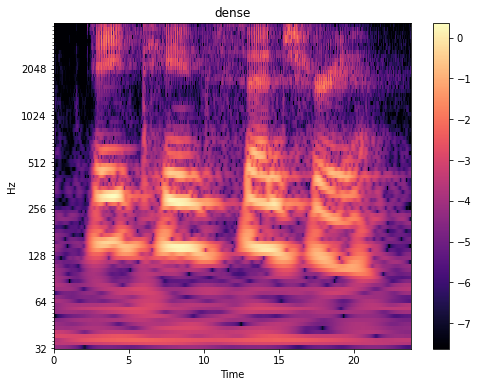

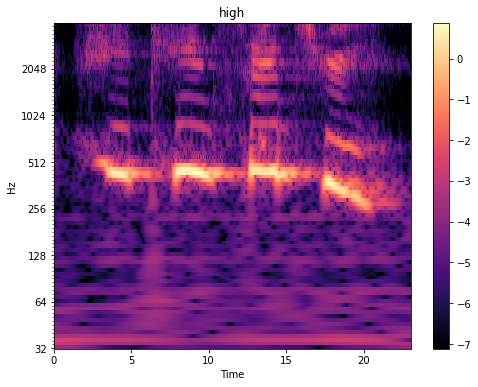

In [37]:
#cqt = get_transform("cqt", n_bins_mult = 150, y_axis = "hz", norm = 1, method = "pow" ) #filter_scale = 0.2
NBINS = 100

#plt.subplot(1,2,1)
cqt_low_pitch = get_transform("cqt", 
                              y_axis = "cqt_hz", 
                              n_bins_mult = NBINS, 
                              fmin = 32.7)
                              #hop_length_mult = 1)
plt.title("dense")
save_pickle("18th_cqt_low", cqt_low_pitch)

#plt.subplot(1,2,2)
cqt_high_pitch  = get_transform("cqt", y_axis = 'cqt_hz', pth = pth_high,  n_bins_mult = NBINS)
plt.title("high")
save_pickle("18th_cqt_high", cqt_high_pitch)


In [23]:
# At the moment log(power) and default db setting appear the same. consider custom functions.


fourier = get_transform("stft", n_bins_mult = 150, method = "pow") # y_axis = "log",)
save_pickle("fourier_power_low", fourier_db_low)

pth_high = "/Users/hayden/Desktop/18th_century_high.m4a"
plt.title("dense")
fourier = get_transform("stft", n_bins_mult = 150, # y_axis = "log",
                       pth = pth_high, method = "pow")
plt.title("high")

transform_type: stft
257
{'sr': 48000, 'n_fft': 512}
(257, 512)


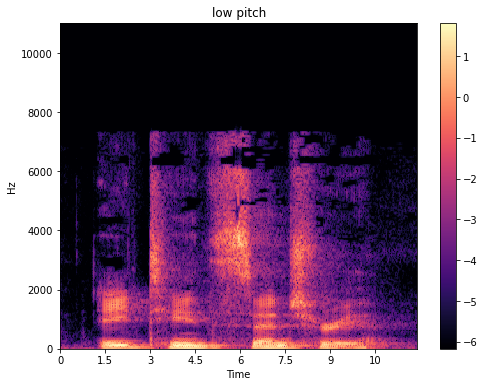

transform_type: stft
257
{'sr': 48000, 'n_fft': 512}
(257, 496)


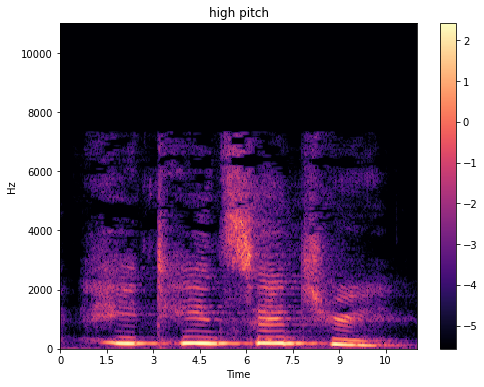

In [38]:

fourier_db_low = get_transform("stft", n_bins_mult = 150)
save_pickle("18th_ft_low", fourier_db_low)
plt.ylim = (0,6500)
plt.title("low pitch")
plt.show()
pth_dense = "/Users/hayden/Desktop/18th_century_high.m4a"
fourier_db_high = get_transform("stft", n_bins_mult = 150, y_axis = "hz",
                       pth = pth_dense)

plt.title("high pitch")
save_pickle("18th_ft_high", fourier_db_high)

In [25]:
hi = fourier["transform"]["Xdb"]
plt.imshow(np.rot90(hi, k = 1, axes = (0 , 1) ))
hi = fourier["transform"]["f"]
hi

NameError: name 'fourier' is not defined

transform_type: cqt
84
{'fmin': 32.7, 'n_bins': 84}
(84, 992)


Text(0.5, 1.0, 'constant q transform: high pitch')

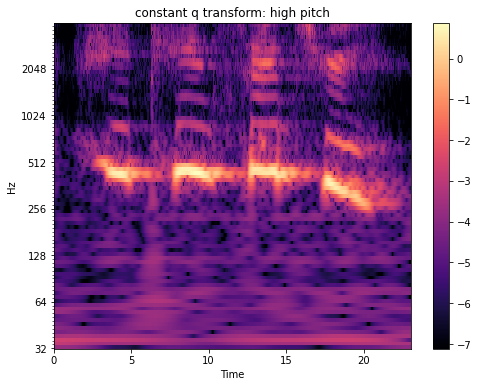

In [26]:
pth_dense = "/Users/hayden/Desktop/18th_century_high.m4a"
fourier = get_transform("cqt", n_bins_mult = 150, y_axis = "cqt_hz",
                       pth = pth_dense)
plt.title("constant q transform: high pitch")

In [ ]:
fourier = get_transform("cqt", n_bins_mult = 150, y_axis = "cqt_hz")
plt.title("constant q transform: low pitch")

In [ ]:
#librosa.fft_frequencies(sr=22050, n_fft=2048)
freqs = librosa.fft_frequencies(sr=22050, n_fft=N_FFT)#2048)
print(len(freqs))
plt.hist(freqs)

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

In [ ]:
Xdb

In [ ]:
%run -i '../MARIOS/PyFiles/imports.py'
%run -i '../MARIOS/PyFiles/helpers.py'
%run -i "../MARIOS/PyFiles/experiment.py"

exper_ = get_experiment(experiment_lst[0], plot_split = False, compare_ = False)
print(exper_.A.shape)

In [ ]:

librosa.display.specshow(exper_.A.T, y_axis='cqt_note', x_axis='time')

# convert dB to Pascals: (Pa)

https://www.translatorscafe.com/unit-converter/en-US/sound-pressure-level/2-9/pascal-sound%20pressure%20level%20in%20decibels/#:~:text=Sound%20pressure%20level%20Lp,20%20%CE%BCPa%20or%200.00002%20Pa)

"Sound pressure level (SPL) is a logarithmic (decibel) measure of the sound pressure relative to the reference value of 20 μPa threshold of hearing. The threshold of hearing is the quietest sound that most young healthy people can hear. Sound pressure level Lp is measured in decibels (dB) and is calculated as follows:"

$L_p = 20*log_{10} (p/p_0)$

Thus:
$(p/p_0) = 10^{L_p/20}$

usually $p_0 = 20 \mu $ Pa or 0.00002 Pa

"The sound pressure level is an absolute value because it is referenced to another absolute value — the threshold of hearing. Therefore, the sound pressure in linear values like pascals can be converted into the sound pressure level in decibels and vice versa if the reference sound pressure is known."

So p = 0.00002 * 10^{L_p/20}

# convert dB to Intensity of sound: 

https://www.omnicalculator.com/physics/db#sound-intensity-level-sil

Sound intensity is defined as the sound wave power per unit area. It is a special quantity that allows us to measure the energy of sound (or, to be more precise, the energy per second per one squared meter).

SIL = $10*log_{10}\left(\frac{I}{I_{ref}}\right)$

where:
SIL is the sound intensity level in dB;
I is the sound intensity in watts per squared meter;
Iref is the reference value if sound intensity. Typically, it is assumed to be equal to 1×10⁻¹² W/m².

$$I = 10^{\frac{SIL}{10}-12}$$

# The threshold of hearing:
The threshold of hearing is generally reported as the RMS sound pressure of 20 micropascals, i.e. 0 dB SPL, corresponding to a sound intensity of 0.98 pW/m2 at 1 atmosphere and 25 °C.[3] It is approximately the quietest sound a young human with undamaged hearing can detect at 1,000 Hz.[4] The threshold of hearing is frequency-dependent and it has been shown that the ear's sensitivity is best at frequencies between 2 kHz and 5 kHz,[5] where the threshold reaches as low as −9 dB SPL.

In [ ]:
sns.distplot(Xdb)

In [ ]:
def log_normal_parameters(array):
    log_array    = np.log(array)
    sample_mu, sample_sigma   = np.mean(log_array), np.std(log_array)
    sample_variance = sample_sigma**2
    estimated_mean = np.exp(sample_mu + 0.5*sample_variance)
    estimated_variance = estimated_mean**2 * (np.exp(sample_variance) - 1)
    
    est_params = {"mean" : estimated_mean,
                  "sd" :   np.sqrt(estimated_variance)}
    return(est_params)

def dB2Pa(db_np, normalize = False, drop_silent = False):
    """
    converts a decibel level to pascals, for numpy arrays
    
    if normalize is set to true it normalizes the data assuming a log-normal distribution.
    
    if drop_silent is true, the function will flatten sounds not hearable by the human ear ( less that 20 * 10-6 pascals)
    """
    p0 = 0.00002
    pa_np = 10**(db_np/20)* p0 
    
    hearing_threshold = 20 * 10 **(-6)
    faint_sounds = pa_np < hearing_threshold
    """
    if normalize: #pa_np has a log-normal distribution: https://stats.stackexchange.com/questions/173715/calculate-variance-and-standard-deviation-for-log-normal-distribution
        pa_np = np.log(pa_np) # it has a log-normal distribution roughly, so we transform, normalize, then transform back
        pa_np = (pa_np - np.mean(pa_np))/np.std(pa_np)
        pa_np = np.exp(pa_np)
        
     
    """
    if normalize: #pa_np has a log-normal distribution: https://stats.stackexchange.com/questions/173715/calculate-variance-and-standard-deviation-for-log-normal-distribution
        params = log_normal_parameters(pa_np)
        print(params)
        mn, sig = params["mean"], params["sd"]
        hearing_threshold = (hearing_threshold - np.exp(mn))/sig
        pa_np = (pa_np - mn)/sig
    
    
        
    
    
    #Flatten the sounds which the human ear cannot hear. rounding to 5 places preserved the lower bound of human hearing.
    if drop_silent:
        pa_np[faint_sounds] = np.round(pa_np[faint_sounds], 6)
        #new lower bound to avoid 0 values:
        pa_np_threshold = 0.000002 #20 * 10 ** (-7)
        pa_np[pa_np < pa_np_threshold] = pa_np_threshold
    return(pa_np)


def dB2Intensity(db_np):
    """
    converts a decibel level to pascals, for numpy arrays
    *
    """
    power = db_np/10 -12
    Intensity = np.power(10, power)
    return(Intensity)



In [ ]:
a = dB2Pa(Xdb, normalize = False)
np.log(20 * 10**(-6))

In [ ]:
sns.distplot(np.log10(Xdb)) #Log- Normal!
min_sound_human_hearing = 20 * (10**-6) #min sound human can percieve in pascals
plt.axvline(x=np.log10(min_sound_human_hearing) , color = "red")

In [ ]:
a = dB2Pa(Xdb, normalize = True)
sns.distplot(np.log10(a))
plt.axvline(x=np.log10(min_sound_human_hearing) , color = "red")

#Log- Normal!
#min_sound_human_hearing = 20 * (10**-6) #min sound human can percieve in pascals
#plt.axvline(x=np.log10(min_sound_human_hearing) , color = "red")

In [ ]:
Xdb.shape

In [ ]:
a = dB2Pa(Xdb, normalize = True)
a#sns.distplot(np.log(a))

20 micro Pascals
The softest sound a normal human ear can detect has a pressure variation of 20 micro Pascals, abbreviated as µPa, which is 20 x 10-6 Pa ("20 millionth of a Pascal") and is called the Threshold of Hearing.

In [ ]:
Xdb.shape

In [ ]:
def add_experiment_regions(ax):
    def fill_region(lb, ub, color_):
        ax.axhline(y=lb, color = color_, linestyle='-')
        ax.axhline(y=ub, color = color_, linestyle='-')
        x  = np.arange(0.0, 27, 0.1)
        y1 = lb + 0 * x
        y2 = ub + 0 * x
        ax.fill_between(x, y2, y1, alpha = 0.2, color = color_)
    
    fill_region(250, 1250, "g")
    
    fill_region(1500, 2500, "b")
    
    fill_region(3500, 4500, "r")
    #plt.show()
    
def linear_log_comparison(inputt = exper_, 
                          method = "propto-dB", 
                          propto = True, 
                          normalized = True,
                          log = False,
                          drop_silent = True):
    
    if type(inputt) != type(np.array([])):
        dataset = inputt.A_unnormalized
    else:
        dataset = inputt

    # we are only proportional because we have normalized the data.
    assert method in ["propto-dB", "propto-SIL", "propto-Pa"], "choose decibels or sound energy"
    
    if method == "propto-SIL":
        plot_value_label = "SIL "
        dataset = dB2Intensity(dataset)
        if log:
            dataset = np.log(dataset)/np.log(10)
        ylab = 'SIL (Sound Intensity Level)'  #sound wave power per unit area')
            #dataset = (dataset - np.mean(dataset))/np.std(dataset) <-- gets you  what you started with
    elif method == "propto-Pa":
        plot_value_label = " (Pa)" #sound pressure
        ylab = "Pascal"
        dataset = dB2Pa(dataset, normalize = normalized, drop_silent = True)
        if log:
            dataset = np.log(dataset)
    else:
        plot_value_label = " (dB)" # decibels
        ylab = "Hz"
        lower_db_limit = -20
        
        if normalized:
            dataset = (dataset - np.mean(dataset))/np.std(dataset)
            lower_db_limit = (lower_db_limit - np.mean(dataset))/np.std(dataset) 
        if drop_silent:
            dataset[dataset < lower_db_limit] = lower_db_limit
            
    
    plot_title = " spectrogram of '18th century'" + plot_value_label
    
    plt.figure(figsize = (12,8))
    
    # Linear spectogram Plot
    ax1 = plt.subplot(1,2,1)
    librosa.display.specshow(dataset, y_axis='linear', x_axis='time')
    
    #display(quadmesh_.get_axes()) # get the first line, there might be more

    #print(ax1.get_axes())#.get_xdata())
    #print(plt.get_xdata())
    plt.title('Linear ' + plot_title)
    add_experiment_regions(ax1)
    plt.ylabel("Hz")
    
    #legend
    legend_elements = [Patch(facecolor='pink', edgecolor='red',     label='3500 to 4500 Hz'),
                       Patch(facecolor='lightblue', edgecolor='blue',   label='1500 to 2500 Hz'),
                       Patch(facecolor='palegreen', edgecolor='green', label='250 to 12250 Hz')]
    plt.legend(handles=legend_elements, loc='upper left')

    # Log spectogram Plot
    ax2 = plt.subplot(1,2,2)
    librosa.display.specshow(dataset, y_axis='log', x_axis='time')
    plt.title('Log ' + plot_title)
    add_experiment_regions(ax2)
    plt.ylabel("Hz")
    
    
    
    if method == "propto-dB":
        propto_str = '%+2.0f' + str(r'$\propto$') if propto else '%+2.0f'
        colorbar_label = propto_str +" dB" #+
    elif method == "propto-SIL":
        colorbar_label = "%+2.0f e-12 SIL"  # + propto_str + 
    elif method == "propto-Pa":
        colorbar_label = "%.1e + Pa"  # propto_str +

    plt.colorbar(format= colorbar_label)

    plt.tight_layout()


### Decibel spectogram (normalized)

In [ ]:
#linear_log_comparison(inputt = Xdb)
pd.DataFrame(Xdb)

# Decibel spectogram, unnormalized

In [ ]:
linear_log_comparison(exper_, 
                      propto = False, 
                      normalized = False,
                      drop_silent = True) 

# Pascal spectogram, normalized

In [ ]:
linear_log_comparison(exper_, method = "propto-Pa", normalized = True)

# Pascal spectogram, unnormalized

In [ ]:
linear_log_comparison(exper_, method = "propto-Pa", normalized = False)

# Lets look at the average sound pressure per log frequency

In [ ]:
dB2Pa(exper_.A_unnormalized)

In [ ]:
linear_log_comparison(inputt = Xdb, method = "propto-Pa", drop_silent = False)

In [ ]:
plt.imshow(exper_.A)

In [ ]:
def create_log_spectogram(dataset = exper_.A, f_arr = exper_.f):
    
    T = exper_.T
    plt.imshow(dataset)
    
    f = np.array(f_arr)[1:] # humans hearing ranges from 20 db to 20k db so lets drop 0 to avoid -infty.
    dataset = dataset[:,1:]
    
    f = np.log(f)/np.log(2) # humans experience sound logarithmically
    
    sns.distplot(f)
    n_timesteps, n_frequencies  = dataset.shape

    for i, time_step in enumerate(range(n_timesteps)):
        if not i:
            dictt_lst = []
        this_timestep = list(T[time_step]) * n_frequencies
        
        assert len(f) == len(this_timestep), "error: " + str(len(f)) + " != " + str(len(this_timestep))
                                 
        dictt_lst += [{"frequency" : list(f) , 
                       "amplitude" : list(dataset[time_step, :]), 
                       "time"      : this_timestep  }]
        #display(pd.DataFrame(dictt_lst))
    
    log_frequency_df = pd.DataFrame(dictt_lst)
    sns.heatmap(x = "frequency", y = "time", values = "amplitude", data = log_frequency_df)
    
create_log_spectogram()

In [ ]:
librosa.display.specshow(Xdb, y_axis='log', x_axis='time')
plt.title('log Power spectrogram')
plt.tight_layout()

In [ ]:
plt.imshow(Xdb, aspect = 10)#.shape

In [ ]:
def partition_song(array, x_start, y_start, y_stop):
    print(array.shape)
    x_stop = x_start + 3000
    partitioned_array = array[y_start:y_stop, x_start:x_stop].copy()
    print(partitioned_array.shape)
    return(partitioned_array)
Xdb_ = partition_song(Xdb, 15000, 0, 800)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (12,6))
xDbRot = np.rot90(Xdb_, k=2, axes=(0, 1))
sns.heatmap(xDbRot, ax = ax)

In [ ]:
plt.imshow(), aspect = 2)

In [ ]:
f_ = cqt["transform"]["f"]
display(f_)


In [ ]:
bounds_ = f_[1], f_[15] #_ denotes temporary variable, for testing or within a function.

lb_, ub_ = bounds_

def retrieve_freqs_btwn(bounds, f_):
    f = np.array(f_)
    lb, ub = bounds
    display(bounds_)
    lb_bool_vec, ub_bool_vec = (f > lb_), (f < ub_)
    and_vector = ub_bool_vec* lb_bool_vec

    freqs = f[and_vector]            #frequencies between bounds
    freq_idxs = np.where(and_vector)[0] #indices between bounds

    return(freq_idxs.tolist())
    
retrieve_freqs_btwn(bounds_, f_)

In [ ]:
"""
def log_amplitude(exper_):
    A = np.array(exper_.A)
    print(np.min(A))
    print(np.max(A))
    orig_shape = A.shape
    
    signs = A.copy().reshape(-1,) < 0
    signs = signs * 2 - 1
    print(np.unique(signs))
    signs = signs.reshape(orig_shape)
    #plt.imshow(signs)
    A_new = np.log(np.abs(A)) * signs
    
    #A_new = (A_new - np.mean(A_new))/ np.std(A_new)
    #print(np.min(A_new))
    #print(np.max(A_new))
    #plt.imshow(A_new)
    return(A_new)
"""